In [1]:
import nets
import torch
import sys
import yaml
import utils
import torchvision.io
import matplotlib.pyplot as plt
from torchvision.transforms import v2, ToTensor
from PIL import Image
import numpy as np
from scipy.stats import wasserstein_distance

device = 'cpu'

def register_extraction_hook(hook, module: torch.nn.Module):
    return module.register_forward_hook(hook)
    
def plot_imgs(images, shape: tuple | None = None):
    plt.figure()
    #subplot(r,c) provide the no. of rows and columns
    if shape is None:
        shape = tuple([1, len(images)])
    nrows, ncols = shape
    f, axarr = plt.subplots(nrows,ncols, figsize=(3.5*ncols, 3*nrows)) 
    # use the created array to output your multiple images
    for img, ax in zip(images, axarr.ravel()):
        ax.imshow(img.permute(1,2,0))
color_conv = {
        0:(0,   0,    0)  , #unlabeled
        1:(200, 0,    0)  , #industrial area
        2:(0,  200,   0)  , #paddy field
        3:(150, 250,  0)  , #irrigated field
        4:(150, 200,  150), #dry cropland
        5:(200, 0,    200), #garden land
        6:(150, 0,    250), #arbor forest
        7:(150, 150,  250), #shrub forest
        8:(200, 150,  200), #park
        9:(250, 200,  0)  , #natural meadow
        10:(200, 200,  0) , #artificial meadow
        11:(0,   0,   200), #river
        12:(250, 0,   150), #urban residential
        13:(0,   150, 200), #lake
        14:(0,   200, 250), #pond
        15:(150, 200, 250), #fish pond
        16:(250, 250, 250), #snow
        17:(200, 200, 200), #bareland
        18:(200, 150, 150), #rural residential
        19:(250, 200, 150), #stadium
        20:(150, 150,   0), #square
        21:(250, 150, 150), #road
        22:(250, 150,   0), #overpass
        23:(250, 200, 250), #railway station
        24:(200, 150,   0), #airport
    }
def mask_to_color(mask):
    global color_conv
    out = torch.zeros((3, mask.shape[0], mask.shape[1]), dtype=torch.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            out[:, r, c] = torch.asarray(color_conv[mask[r,c].item()])
    return out

def class_hist(mask, nclasses):
    out = torch.zeros(nclasses)
    for cl in range(nclasses):
        out[cl] = torch.count_nonzero(mask == cl) / mask.numel()
    return out


import torchmetrics.functional.segmentation
import torchmetrics.functional.classification
from prettytable import PrettyTable

def per_image_jaccard(target_mask_idx, query_masks_idx):
    result = torch.zeros(query_masks_idx.shape[0])
    for i in range(query_masks_idx.shape[0]):
        result[i] = torchmetrics.functional.classification.multiclass_jaccard_index(target_mask_idx, query_masks_idx[i].unsqueeze(0), 25, 'weighted', 0)
    return result

def pixel_precision(target_mask_idx, query_masks_idx):
    return torch.sum((query_masks_idx == target_mask_idx) * (target_mask_idx != 0), dim=(-1,-2)) / target_mask_idx.count_nonzero()

def per_image_emd(target_mask_idx, query_masks_idx):
    no_bg_target = torch.flatten(target_mask_idx.squeeze())
    no_bg_target = no_bg_target[no_bg_target.nonzero(as_tuple=True)]
    query_flat = torch.flatten(query_masks_idx, start_dim=1)
    result = torch.zeros(query_masks_idx.shape[0])
    for i in range(query_masks_idx.shape[0]):
        ith = query_flat[i]
        no_bg_query = ith[torch.nonzero(ith, as_tuple=True)]
        result[i] = wasserstein_distance(no_bg_target.numpy(), no_bg_query.numpy())
    return result
    
def compute_scores(targ_mask_idx, query_masks_idx, num_classes):
    scores = {}
    scores['miou'] = torchmetrics.functional.segmentation.mean_iou(targ_mask_idx.expand((query_masks_idx.shape[0], -1, -1)), query_masks_idx, num_classes, False)
    scores['wiou'] = per_image_jaccard(targ_mask_idx, query_masks_idx)
    scores['pprec'] = pixel_precision(targ_mask_idx, query_masks_idx)
    scores['emd'] = per_image_emd(targ_mask_idx, query_masks_idx)
    return scores

def scores_table(sc, n_img):
    table = PrettyTable(0)
    table.field_names = ["score"] + [f"query{i}" for i in range(n_img)]
    for idx, key in enumerate(sc):
        table.add_row([key] + sc[key].tolist())
    print(table)

def get_best_match_idx(selected_score, scores):
    if selected_score == 'miou' or selected_score == 'wiou' or selected_score == 'pprec':
        selector = torch.argmax
    elif selected_score == 'emd':
        selector = torch.argmin
    else:
        raise ValueError(f"'{selected_score}' is not a valid metric")
    return selector(scores[selected_score])

def plot_best_match_by_score(targ, quer, targ_m_color, quer_m_color, selected_score, scores):
    best_el = get_best_match_idx(selected_score, scores)
    plot_imgs([targ, quer[best_el], targ_m_color, quer_m_color[best_el]], (2,2))

import math   
def visualize_activations(input_act):
    input_act = input_act.numpy()
    nch, m_h, m_w = input_act.shape
    figscale_factor = 512
    if nch > figscale_factor:
        figscale = math.ceil(nch / figscale_factor)
    else:
        figscale = 1
    #Create figure and axes
    fig = plt.figure(figsize=(figscale*10, figscale*10))
        
    #Set up title handling negative layer indexings
    fig.suptitle("title")
    # if layer_idx >= 0:
    #     fig.suptitle("Activations for '" + layer_name + "' " 
    #                  + layer_typename + " layer (" + str(layer_idx) + "/" 
    #                  + str(len(layers_activation_maps) - 1) 
    #                  + ")\nLayer shape: " + str(layer_dims[1:]),
    #                  fontsize = 12 * figscale
    #                 )
    # else:
    #     fig.suptitle("Activations for '" + layer_name + "' " 
    #                  + layer_typename + " layer (" 
    #                  + str(len(layers_activation_maps) 
    #                  + layer_idx) + "/" + str(len(layers_activation_maps) - 1) 
    #                  + ") (idx = " + str(layer_idx) 
    #                  + ")\nLayer shape: " + str(layer_dims[1:]),
    #                  fontsize = 12 * figscale
    #                 )
                     
    #Plot each 2D activation map channel in grid for selected layer          
    #Calculate the number of rows and columns needed to arrange
    #the activation maps into a nearly-square grid. The number of 
    #maps is the number of channels in the convolutional layer output
    col_size = math.ceil(nch ** 0.5)
    row_size = math.ceil(nch / col_size)

    #Get image size of each channel activation map
    act_map_shape = (m_h, m_w)

    #Create a blank grid image with borders
    border_thickness = 1
    grid_image_shape = (
        row_size * (act_map_shape[0] + border_thickness) + border_thickness,
        col_size * (act_map_shape[1] + border_thickness) + border_thickness,
    )

    #Initialise image background
    grid_image = np.empty(grid_image_shape, dtype=np.float32)
    grid_image[:] = np.nan

    #Place images in the grid
    for ch_idx in range(nch):
        #Get row and column coordinates
        row = ch_idx // row_size
        col = ch_idx % col_size
        #Set start coordinates of region of grid image to update
        x = col * (act_map_shape[1] + border_thickness) + border_thickness
        y = row * (act_map_shape[0] + border_thickness) + border_thickness
        #Update grid image values with activation map
        grid_image[y : y + act_map_shape[0],
                   x : x + act_map_shape[1]] = input_act[ch_idx, :, :]

    #Map NaNs to black to form borders between activation maps
    cmap = plt.cm.viridis
    cmap.set_bad('black', 1.)

    #Turn off x-ticks
    plt.xticks([],[])

    #Add y-ticks labelling rows with their activation map channel ranges
    # Generate labels
    ytick_labels = [str(i*col_size) + " - " + str(i*col_size + row_size - 1) 
                    for i in range(col_size - 1)] \
                 + [str((row_size - 1) * col_size) + " - " + str(nch - 1)]
    #Generate locations
    ytick_locs = [i*(grid_image_shape[1] // len(ytick_labels)) 
                  + 0.5 * (act_map_shape[1] + border_thickness)
                  for i in range(len(ytick_labels))]

    #Set y-tick locations and labels
    plt.yticks(ytick_locs, ytick_labels, fontsize = 10 * figscale)
    plt.imshow(grid_image, cmap=cmap)

In [2]:
n_cls = 15
model = "Unetv2"
chkpt = "/home/pit/Desktop/urnetv2_checkpoint8"

In [3]:
net = utils.load_network({"net": model, "num_classes": n_cls}, device)
checkpoint = torch.load(chkpt, map_location=torch.device(device))
net.load_state_dict(checkpoint['model_state_dict'])
print(net)

Urnetv2(
  (encode1): Sequential(
    (0): UnetEncodeLayer(
      (layer): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): UnetEncodeLayer(
      (layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (encode2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): UnetEncodeLayer(
      (layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): UnetEncodeLayer(
      (layer): Sequential(
        (0): Conv2d(12

In [4]:
# import torchvision.transforms.v2


# img = Image.open('/home/pit/University/CVCS/sentinel-imgs/big.png')
# tensor_converter = torchvision.transforms.ToTensor()
# cropper = torchvision.transforms.v2.RandomCrop(224)
# tns = ToTensor()
# target = tns(cropper(img))
# v2.functional.to_pil_image(target).save('/home/pit/University/CVCS/sentinel-imgs/target.png')
# for i in range(10):
#     query = tns(cropper(img))
#     v2.functional.to_pil_image(query).save(f'/home/pit/University/CVCS/sentinel-imgs/query{i}.png')

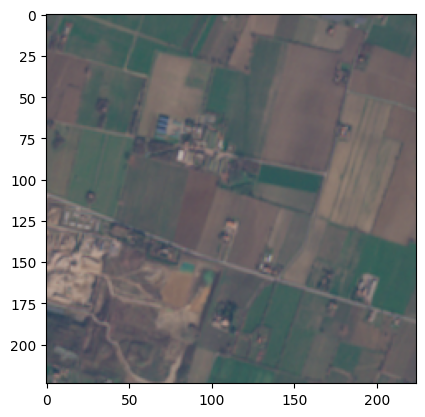

In [5]:
img_dir = "/home/pit/University/CVCS/sentinel-imgs/"
tensor_converter = torchvision.transforms.ToTensor()
#read base image
target = tensor_converter(Image.open(img_dir + "target.png"))[:3,:,:]
plt.imshow(target.permute(1,2,0))

In [6]:
#read target images
# query_dim = 224
# cropper = v2.RandomCrop(query_dim)
# big_img = tensor_converter(Image.open(target_path))[1:,:,:]
# queries = [cropper(big_img) for _ in range(10)]
import glob
query_fnames = glob.glob("query*", root_dir=img_dir)
queries = [tensor_converter(Image.open(img_dir+q))[:3,:,:] for q in query_fnames]

In [ ]:
plot_imgs(queries)

Now we run a forward pass of the selected model to extract intermediate features for the _base_ example:

In [ ]:
base_feature = None
def take_base_feature(module, args, output):
    global base_feature
    base_feature = output.clone()

layer = net.encode5

handler = register_extraction_hook(take_base_feature, layer)
with torch.no_grad():
    target_mask = net(target.unsqueeze(0))

handler.remove()

assert(base_feature is not None)

The same thing is done for the set of target images. The forward pass is run in batched mode, and the features extracted are batched too.

In [ ]:
features = None

def take_target_features(module, args, output):
    global features
    features = output.clone()

layer = net.encode5
handler = register_extraction_hook(take_target_features, layer)
with torch.no_grad():
    query_masks = net(torch.stack(queries))

handler.remove()

# Estimating similarity
Our main goal is that of finding which query image can be most closely associated with the target image.
We start our analysis by computing various scores between the segmentation mask of our target image and the queries.
## Selected scores
- **mean IoU**
- **weighted IoU**
- **pixel overlap**: simply the percentual amount of overlap between two segmentation masks as $$po(t,q) = \frac{1}{N}\sum_{s=1}^{N}\mathbb{1}[t_s=q_s]$$
- **Earth Mover's Distance**: EDM between segmentation mask histograms.

## Some thoughts on scores and the concept of similarity in semantic segmentation
The main question that should guide this quest on esimating similarity is: what do we mean by "similar" images in the case of semantic segmentation of satellite colour images? I want to start with some consideration on the metrics used. 

Both IoU metrics as well as pixel overlap are heavily influenced by the spatial characteristics of images (and masks). As a thought experiment, think of a shoreline, obviously observed in bird's eye view: we can easily picture a very simmetric image, with a line created where the water meets the sand; now think of the same image but flipped by 180 degrees. Sand and water "swithced places", but the overall content is the very same. How would such an image score with these metrics, taking the original as our ground truth? It's trivial to conclude that there would be little overlap for both classes (observe that the overlap for at least one class grows the more the separation line is distant from the center of the image). If we instead take an image where only sand (or water) is visible, this image would counterintuitively score higher than the transformed image, even though we could consider it semantically different since one object class is completely missing.

EMD on the other hand completely discards spatial information, since it measures the minimal effort required to "morph" one distribution into another: in our case the distribution is the dense pixel classifications output by the segmentation model (which is represented using normalized histograms). Going back to the previous example, now the transformed image would be the highest scoring, since it contains the exact same pixels.
> In fact the EMD paper defines a ground distance that considers the spatial information of a pixel plus its color...

In [ ]:
query_masks_idx = torch.argmax(query_masks, dim=1)
target_mask_idx = torch.argmax(target_mask, dim=1)

scores = compute_scores(target_mask_idx, query_masks_idx, 16)
scores_table(scores, len(query_masks_idx))

In [ ]:
target_mask_color = mask_to_color(target_mask_idx.squeeze())
query_masks_color = [mask_to_color(mask) for mask in list(query_masks_idx[:])]

In [ ]:
plt.imshow(target_mask_color.permute(1,2,0))

In [ ]:
plot_imgs(query_masks_color)

In [ ]:
score = 'emd'

plot_best_match_by_score(target, queries, target_mask_color, query_masks_color, score, scores)

In [ ]:
visualize_activations(base_feature.squeeze())

In [ ]:
def visualize_activation_channel(features, channel):
    plt.matshow(features[channel], cmap='viridis')

visualize_activation_channel(base_feature.squeeze(), 912)

In [ ]:
visualize_activations(features[get_best_match_idx('emd', scores)])

# Segformer

In [7]:
net = utils.load_network({"net": "segformer_2", "num_classes": 16}, device)
utils.load_checkpoint({"load_checkpoint": "/home/pit/Desktop/segformer_2_checkpoint", "device": device}, net)
print(net)

Loaded checkpoint /home/pit/Desktop/segformer_2_checkpoint
segformer_2(
  (segformer): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(320, 512, kernel_

In [8]:
encoded_target = None
encoded_queries = None

def take_encoded_t(module, args, output):
    global encoded_target
    encoded_target = output.last_hidden_state.clone()

def take_encoded_q(module, args, output):
   global encoded_queries
   encoded_queries = output.last_hidden_state.clone()

layer = net.segformer.segformer.encoder


with torch.no_grad():
    handler = register_extraction_hook(take_encoded_t, layer)
    target_mask = net(target.unsqueeze(0))
    handler.remove()
    handler = register_extraction_hook(take_encoded_q, layer)
    query_masks = net(torch.stack(queries))
    handler.remove()

query_masks_idx = torch.argmax(query_masks, dim=1)
target_mask_idx = torch.argmax(target_mask, dim=1)

target_mask_color = mask_to_color(target_mask_idx.squeeze())
query_masks_color = [mask_to_color(mask) for mask in list(query_masks_idx[:])]

In [ ]:
plt.imshow(target_mask_color.permute(1,2,0))

In [ ]:
plot_imgs(query_masks_color)

In [ ]:
scores = compute_scores(target_mask_idx, query_masks_idx, 16)
scores_table(scores, len(queries))

In [ ]:
plot_best_match_by_score(target, queries, target_mask_color, query_masks_color, 'emd', scores)

In [ ]:
visualize_activations(encoded_target.squeeze())

In [ ]:
visualize_activations(encoded_queries[get_best_match_idx('emd', scores)])

In [9]:
import sys
sys.modules.pop('utils')
del utils
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
sys.modules.pop('utils')
import utils
with torch.no_grad():
    vit_feats_target = vits8(target.unsqueeze(0))
    vit_feats_queries = vits8(torch.stack(queries))

Using cache found in /home/pit/.cache/torch/hub/facebookresearch_dino_main


DINO ViT's features can be used as a k-NN classifier. Should be able to find the most similar image by computing the L2 distance between the produced features

<Figure size 640x480 with 0 Axes>

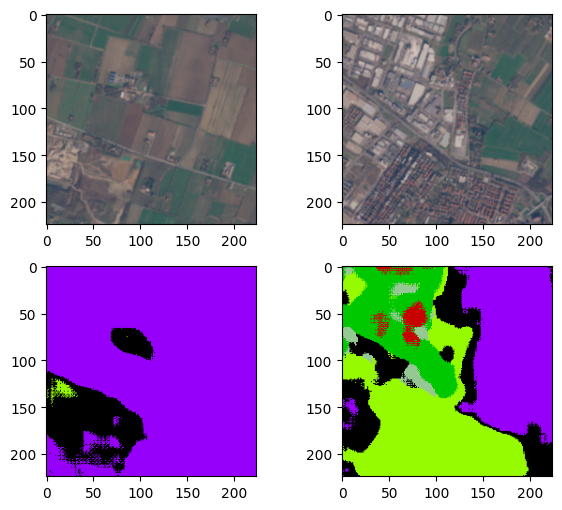

In [13]:
l2 = torch.cdist(vit_feats_queries.unsqueeze(0), vit_feats_target.unsqueeze(0)).squeeze()
max_el = torch.argmax(l2)
plot_imgs([target, queries[max_el], target_mask_color, query_masks_color[max_el]], (2,2))